## Introduction
---
- We have a dataset containing information about a mall's customers and their spending scores.
- The goal is to cluster the customers based on their features.

- Our dataset contains:
    - CustomerID : ID assigned to the customer
    - Gender : Gender of the customer
    - Age : Age of the customer
    - Annual Income (k$) : Annual Income of the customer
    - Spending Score (1-100) : Score assigned by the mall based on customer behavior and spending nature

## Initial libraries and functions
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans 

In [2]:
def calculate_WCSS(points, kmax):
    """
    Calculates the Within-Cluster Sum of Squares (WCSS) for a range of cluster values (k) 
    using the K-Means algorithm, to aid in determining the optimal number of clusters 
    via the Elbow Method.

    Parameters:
        points : array-like of shape (n_samples, n_features)
            The dataset to cluster, where each row is a sample, and each column is a feature.
    
        kmax : int
            The maximum number of clusters (k) to evaluate. WCSS will be calculated for each 
            k from 1 to kmax.

    Returns:
        WCSS : numpy.ndarray of shape (kmax + 1,)
            A 1D array where the value at index k contains the WCSS for k clusters. 
            The index 0 will be unused and contain 0 by default.
    """
    WCSS = np.zeros(kmax+1)
    
    for k in range(1, kmax+1):
        kmeans_model = KMeans(init = "k-means++", n_clusters = k, n_init = 12).fit(points)
        WCSS[k] = kmeans_model.inertia_
    
    return WCSS

## Exploratory data analysis (EDA)
---
- Dataset looks clean, doesn't require cleaning that much.

In [3]:
df = pd.read_csv('customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.isna().sum(), df.duplicated().sum()

(CustomerID                0
 Gender                    0
 Age                       0
 Annual Income (k$)        0
 Spending Score (1-100)    0
 dtype: int64,
 0)

### Proprocessing
- Dropping `customerID`
- Renaming fields for easier access
- Changing types to float64

In [6]:
df.drop('CustomerID', axis='columns', inplace=True)

df.rename(
    {
        'Annual Income (k$)' : 'income',
        'Spending Score (1-100)' : 'score'
    },
    axis='columns',
    inplace=True
)
df.rename(str.lower, axis='columns', inplace=True)

df[['age', 'income', 'score']] = df[['age', 'income', 'score']].astype('float64')

df.head()

,gender,age,income,score
0,Male,19.0,15.0,39.0
1,Male,21.0,15.0,81.0
2,Female,20.0,16.0,6.0
3,Female,23.0,16.0,77.0
4,Female,31.0,17.0,40.0


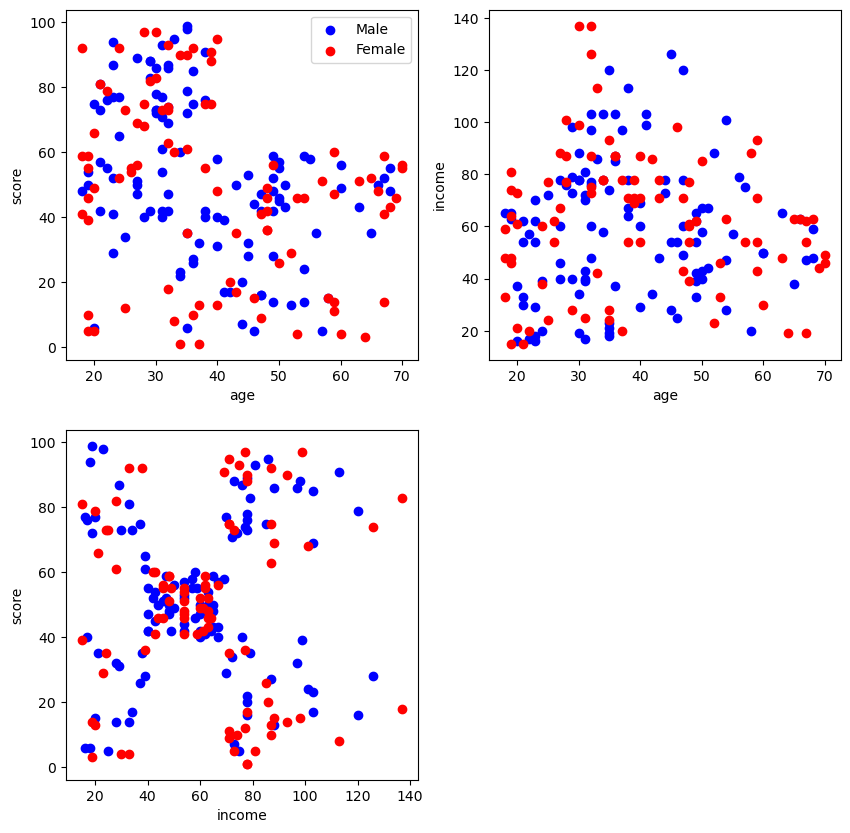

In [7]:
# I thought gender might affect the clustering, but it seems I may be wrong. However, it still needs to be proven.
females, males = df[df.gender == 'Female'], df[df.gender == 'Male']

fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1, xlabel='age', ylabel='score')
plt.scatter(females.age, females.score, c='b')
plt.scatter(males.age, males.score, c='r')
plt.legend(['Male', 'Female'])

plt.subplot(2, 2, 2, xlabel='age', ylabel='income')
plt.scatter(females.age, females.income, c='b')
plt.scatter(males.age, males.income, c='r')

plt.subplot(2, 2, 3, xlabel='income', ylabel='score')
plt.scatter(females.income, females.score, c='b')
plt.scatter(males.income, males.score, c='r')

## K-means clustering
---
- We need to find the optimal number of clusters (K), which can be done using the Elbow Method.
- I believe K = 4 is where the plot starts decreasing much more slowly.

### Proprocessing

In [8]:
df.gender = LabelEncoder().fit(['Female', 'Male']).transform(df.values[:, 0])

X = df

X_scaled = MinMaxScaler().fit_transform(X)

X[:5], X_scaled[:5]

(   gender   age  income  score
 0       1  19.0    15.0   39.0
 1       1  21.0    15.0   81.0
 2       0  20.0    16.0    6.0
 3       0  23.0    16.0   77.0
 4       0  31.0    17.0   40.0,
 array([[1.        , 0.01923077, 0.        , 0.3877551 ],
        [1.        , 0.05769231, 0.        , 0.81632653],
        [0.        , 0.03846154, 0.00819672, 0.05102041],
        [0.        , 0.09615385, 0.00819672, 0.7755102 ],
        [0.        , 0.25      , 0.01639344, 0.39795918]]))

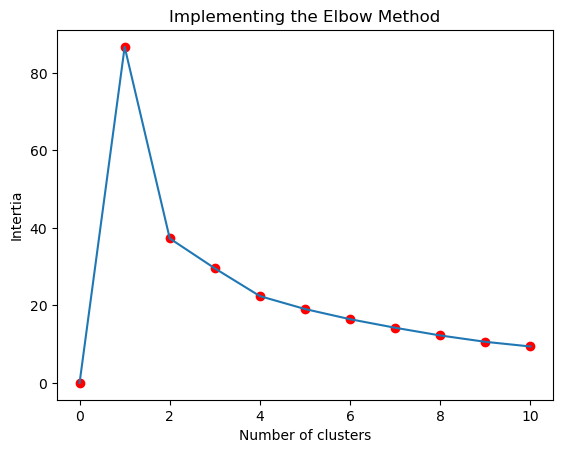

In [9]:
wcss = calculate_WCSS(X_scaled, 10)

plt.plot(wcss)
plt.scatter(np.arange(11), wcss, c='r')
plt.title('Implementing the Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Intertia')

plt.show()

### Training our model and describing it

In [10]:
k=4
kmeans_model = KMeans(init = "k-means++", n_clusters = k, n_init = 12).fit(X)

df['cluster'] = kmeans_model.labels_

In [11]:
df.groupby('cluster').describe().T

cluster                0          1           2          3
gender count   39.000000  95.000000   38.000000  28.000000
       mean     0.461538   0.378947    0.526316   0.500000
       std      0.505035   0.487699    0.506009   0.509175
       min      0.000000   0.000000    0.000000   0.000000
       25%      0.000000   0.000000    0.000000   0.000000
       50%      0.000000   0.000000    1.000000   0.500000
       75%      1.000000   1.000000    1.000000   1.000000
       max      1.000000   1.000000    1.000000   1.000000
age    count   39.000000  95.000000   38.000000  28.000000
       mean    32.692308  44.894737   40.394737  24.821429
       std      3.728650  15.341831   11.376931   5.571446
       min     27.000000  18.000000   19.000000  18.000000
       25%     30.000000  32.000000   34.000000  20.750000
       50%     32.000000  48.000000   41.500000  23.000000
       75%     35.500000  56.000000   47.000000  30.000000
       max     40.000000  70.000000   59.000000  35.000000
income count   39.000000  95.000000   38.000000  28.000000
       mean    86.538462  48.705263   87.000000  28.714286
       std     16.312485  14.522817   16.271348  10.384665
       min     69.000000  16.000000   70.000000  15.000000
       25%     75.500000  40.000000   76.250000  19.750000
       50%     79.000000  54.000000   80.000000  28.000000
       75%     95.000000  61.000000   96.000000  37.250000
       max    137.000000  69.000000  137.000000  48.000000
score  count   39.000000  95.000000   38.000000  28.000000
       mean    82.128205  42.631579   18.631579  74.250000
       std      9.364489  14.713616   10.915947  14.075524
       min     63.000000   3.000000    1.000000  39.000000
       25%     74.500000  40.500000   10.250000  64.000000
       50%     83.000000  47.000000   16.500000  74.000000
       75%     90.000000  52.000000   26.750000  81.250000
       max     97.000000  60.000000   40.000000  99.000000

### Plotting the Segmentation Results of Our Model

In [12]:
centroids = kmeans_model.cluster_centers_[:, 1:]
centroids

array([[32.69230769, 86.53846154, 82.12820513],
       [44.89473684, 48.70526316, 42.63157895],
       [40.39473684, 87.        , 18.63157895],
       [24.82142857, 28.71428571, 74.25      ]])

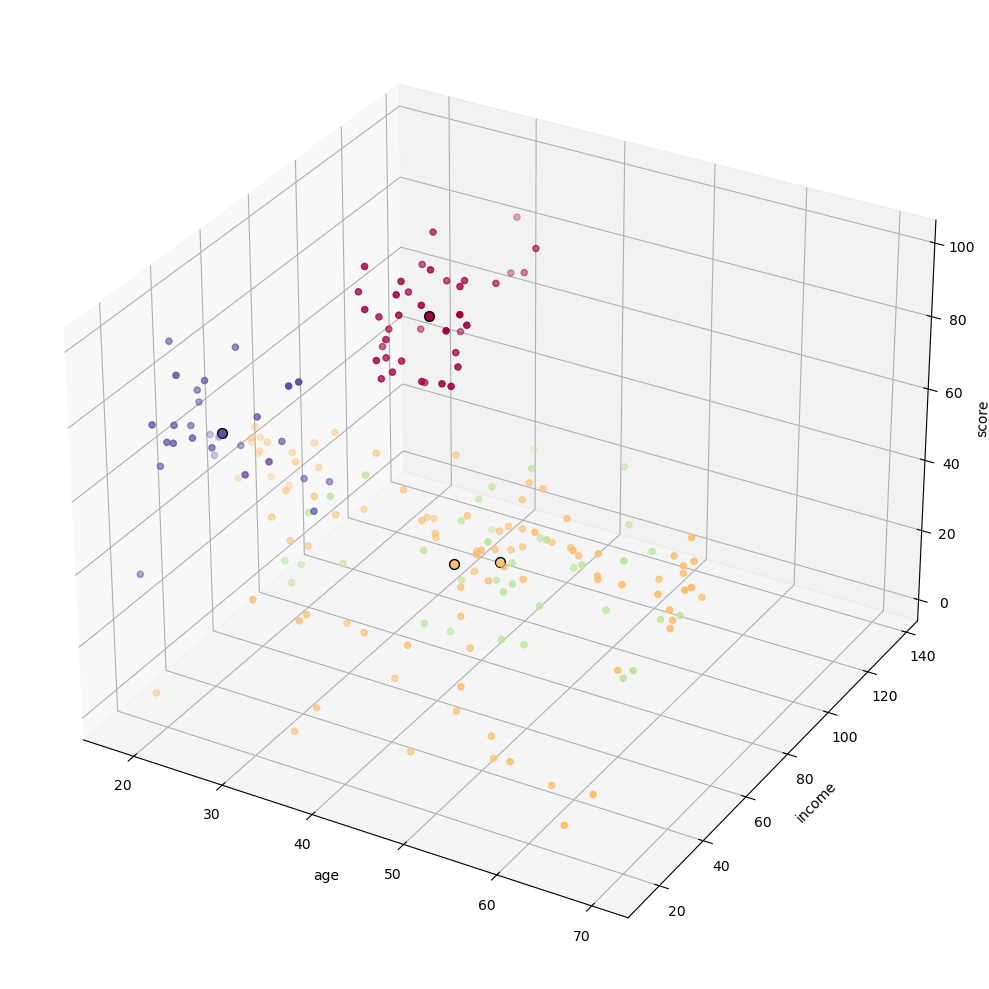

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

colors = plt.cm.Spectral(np.linspace(0, 1, k))

for cluster, color in enumerate(colors):
    sub_df = df[df.cluster == cluster]
    
    x, y, z = sub_df[['age', 'income', 'score']].T.to_numpy()
    
    ax.scatter(x, y, z, color=color)
    ax.scatter(*centroids[cluster], color=color, edgecolor='k', s=50)
    
ax.set_xlabel('age')
ax.set_ylabel('income')
ax.set_zlabel('score')

plt.tight_layout()

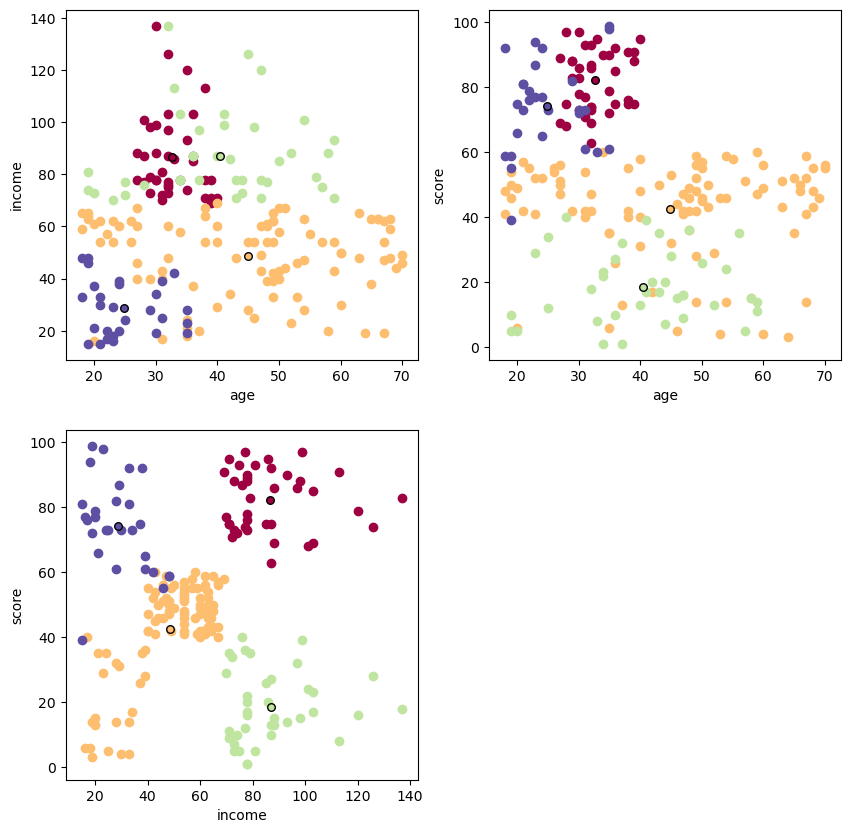

In [14]:
fig = plt.figure(figsize=(10, 10))

colors = plt.cm.Spectral(np.linspace(0, 1, k))

for cluster, color in enumerate(colors):
    sub_df = df[df.cluster == cluster]
    
    age, income, score = sub_df[['age', 'income', 'score']].T.to_numpy()

    plt.subplot(2, 2, 1, xlabel='age', ylabel='income')
    plt.scatter(age, income, color=color)
    plt.scatter(*centroids[cluster][[0, 1]], color = color ,edgecolors='k', s=30)

    plt.subplot(2, 2, 2, xlabel='age', ylabel='score')
    plt.scatter(age, score, color=color)
    plt.scatter(*centroids[cluster][[0, 2]], color = color ,edgecolors='k', s=30)

    plt.subplot(2, 2, 3, xlabel='income', ylabel='score')
    plt.scatter(income, score, color=color)
    plt.scatter(*centroids[cluster][[1, 2]], color = color ,edgecolors='k', s=30)

---
<center>
    <h3>
        <i>
            This concludes the notebook. Feel free to reach out with any questions or suggestions!
        </i>
    </h3>
</center>